Import the libraries necessary to analize data

In [105]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [106]:
df = pd.read_csv('df_scaled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   povertyPercentage          166664 non-null  float64
 1   incident_gravity           166664 non-null  float64
 2   females_rate               166664 non-null  float64
 3   minor_rate                 166664 non-null  float64
 4   arrested_rate              166664 non-null  float64
 5   survival_rate              166664 non-null  float64
 6   winning_party_percentage   166664 non-null  float64
 7   killed_rate                166664 non-null  float64
 8   injured_rate               166664 non-null  float64
 9   killed_disp_per_district   166664 non-null  float64
 10  injured_disp_per_district  166664 non-null  float64
 11  part_disp_per_district     166664 non-null  float64
 12  avg_age_participants       166664 non-null  float64
 13  n_participants             16

We selected one state as stated in subtask of clustering task.

In particular, we decided to select one of states with the highest number of gun incidents, in particular California

In [107]:
df_task_1 = pd.read_csv('../TASK1/df_after_dp.csv')

In [108]:
df['state'].value_counts().head(3)

state
illinois      14276
california    11975
florida        9713
Name: count, dtype: int64

In [109]:
df = df.loc[df['state'] == 'california']

In [110]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'isKilled', 'involve_injury','pc1', 'pc2']

       
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['avg_age_participants',
 'n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'isKilled',
 'involve_injury',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [111]:
df_categorical = df[column_to_drop].copy()
df_numeric = df.drop(columns=column_to_drop)

To choose the best eps value we create the distance matrix 

In [112]:
dist = pdist(df_numeric, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

To choose the epsilon parameter, we will use the elbow method.

In [113]:
k = 10
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

Text(0.5, 0, 'sorted distances')

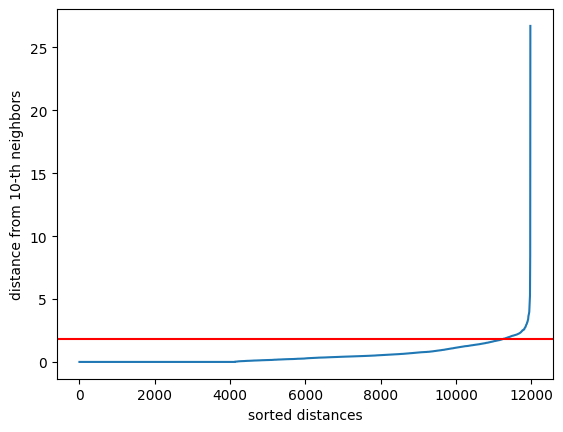

In [114]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.axhline(y=1.8, color='r', linestyle='-')
plt.ylabel(f'distance from {k}-th neighbors')
plt.xlabel('sorted distances')

We can identify the Elbow in the value of 1.8, so this value is a candidate for the Epsilon.

In [115]:
#Coarse grain search for the number of min_samples
#min_samples = [20, 50, 150, 200]
#Finer grain search for the number of min_samples
min_samples = [160,170,180]

#Coarse grain search for the number of eps
#eps_l = [1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.3, 2.5]
#Finer grain search for the number of eps
eps_l = [1.6, 1.7, 1.8]

In [116]:
from sklearn import metrics

table = []
for eps in eps_l:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(df_numeric)
        n_clusters = len(np.unique(dbscan.labels_))
        silhouette = metrics.silhouette_score(df_numeric, dbscan.labels_)
        DBscore = metrics.davies_bouldin_score(df_numeric, dbscan.labels_)
        table.append({"eps":eps, "silhouette": silhouette, "DBscore":DBscore, "n_clusters": n_clusters, "min_samples": min_sample})
        

In [117]:
pd.DataFrame(table).sort_values(by="silhouette", ascending=False)


,eps,silhouette,DBscore,n_clusters,min_samples
0,1.6,0.203067,2.058427,5,160
1,1.6,0.202708,2.052993,5,170
2,1.6,0.200455,2.046920,5,180
5,1.7,0.182855,2.698849,3,180
8,1.8,0.081276,2.612303,4,180
3,1.7,0.070288,2.668464,4,160
4,1.7,0.065675,2.657156,4,170
7,1.8,-0.002433,2.671720,3,170
6,1.8,-0.002674,2.668508,3,160


The best looking value of silhouette is the eps 1.6 with 160 samples.

Plotting the result of the clustering on the pca dimensions (pc1 and pc2), labelling each point by the cluster label

noise points: 3381


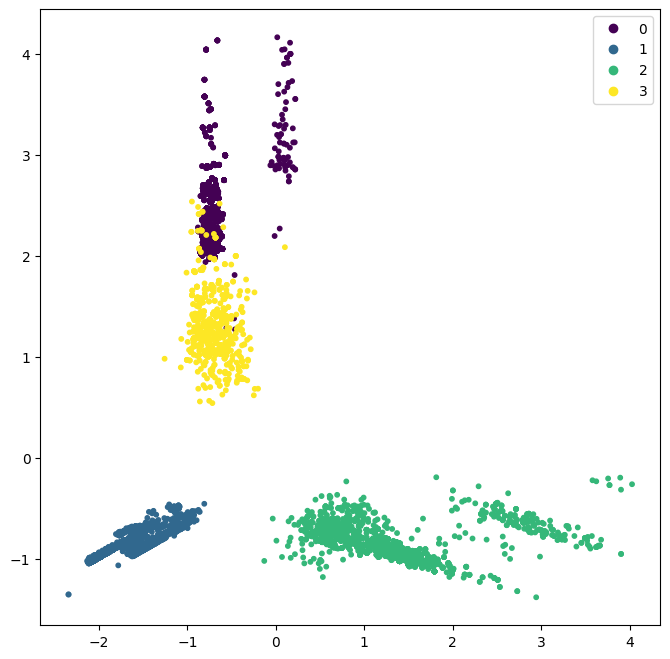

In [118]:
eps = 1.6
min_samples = 160
# Perform DB scan
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(df_numeric)
print(f"noise points: {(dbscan.labels_==-1).sum()}")

plt.figure(figsize=(8,8))
#printing the scatter without -1 labels (noise points)
scatter = plt.scatter(df['pc1'][dbscan.labels_!=-1], df['pc2'][dbscan.labels_!=-1], c=dbscan.labels_[dbscan.labels_!=-1], s=10)
#scatter = plt.scatter(df['pc1'], df['pc2'], c=dbscan.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.legend(*scatter.legend_elements())

In [119]:
# Calculate number of clusters for final dbscan
n_clusters = len(np.unique(dbscan.labels_))-1

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(dbscan.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [1945, 3582, 2457, 610]


Distrubution of the clusters' labels found by the db_scan with the best configuration

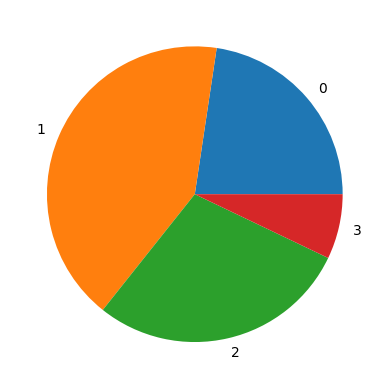

In [120]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Radiant plot

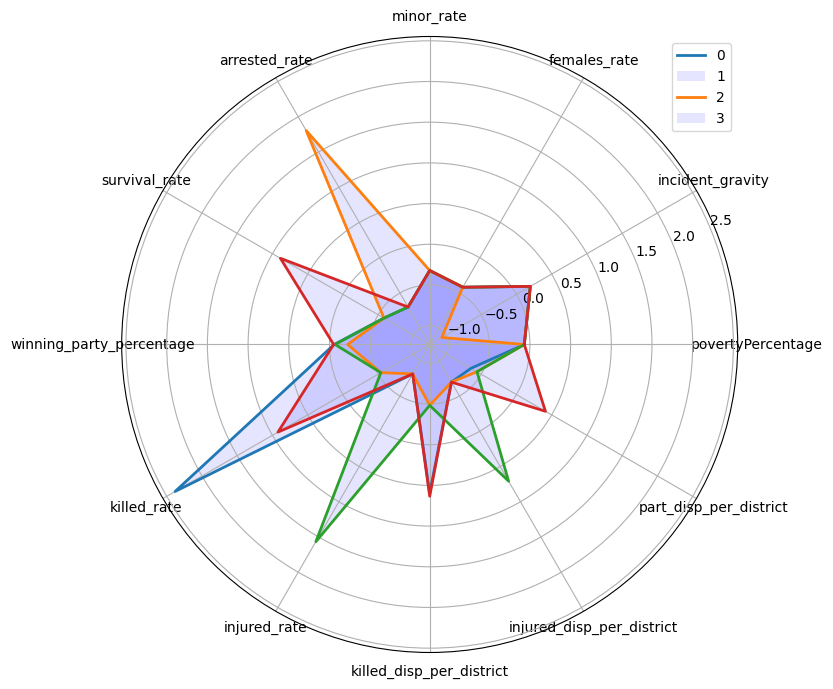

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(df_numeric.columns)
plt.figure(figsize=(8, 8))



for label in np.unique(dbscan.labels_)[1:]:
    angles = [n / float(N) * 2 * math.pi for n in range(N)] 
    values = df_numeric[dbscan.labels_ == label].median().values.tolist()
        
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], df_numeric.columns)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, 'b', alpha=0.1)


plt.legend(labels=np.unique(dbscan.labels_)[1:])


plt.show()


Line plot

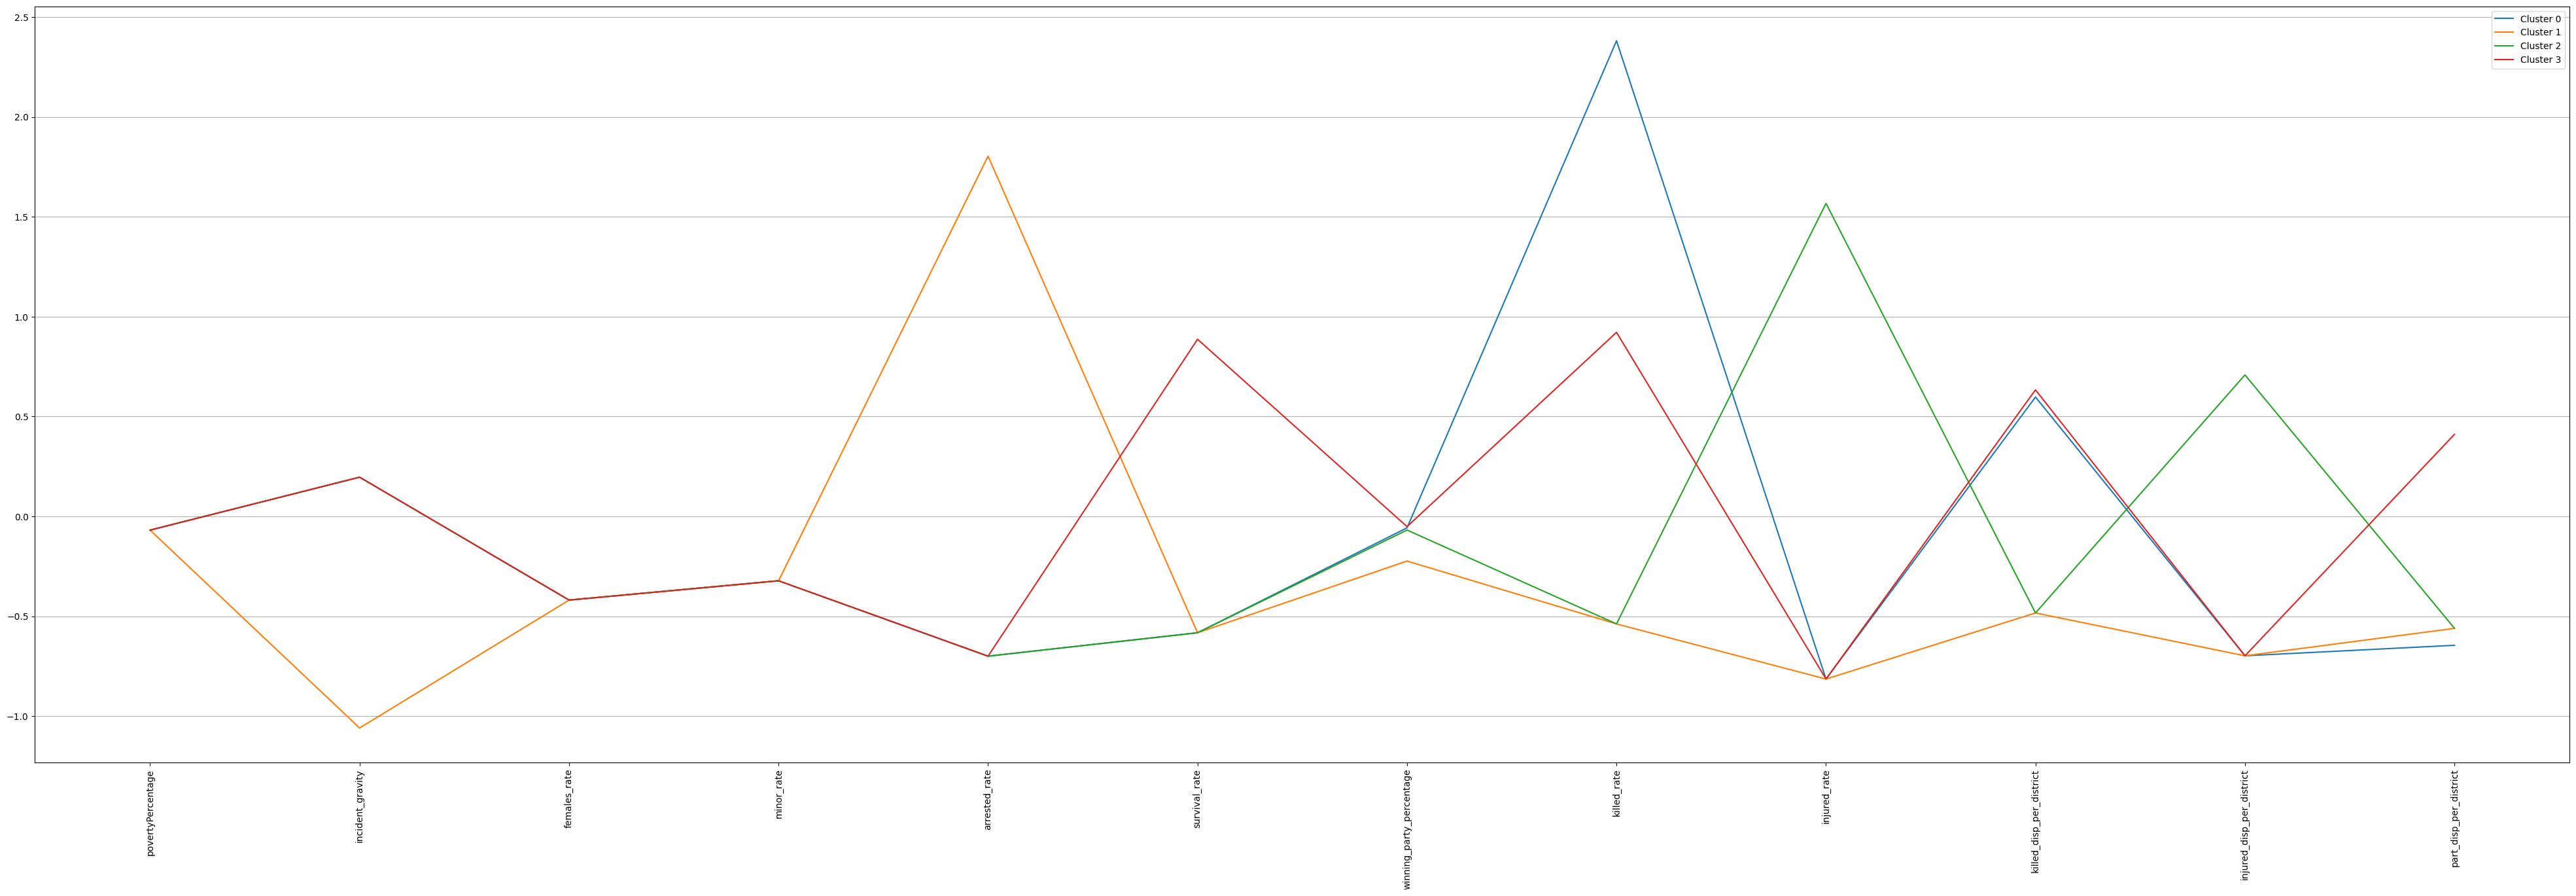

In [122]:
plt.figure(figsize=(50, 15))

for label in np.unique(dbscan.labels_)[1:]:
    cent = df_numeric[dbscan.labels_ == label].median()
    plt.plot(cent, label="Cluster %s" % label)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_numeric.columns)), df_numeric.columns, rotation=90)
plt.legend()
plt.gca().yaxis.grid(True)

plt.show()

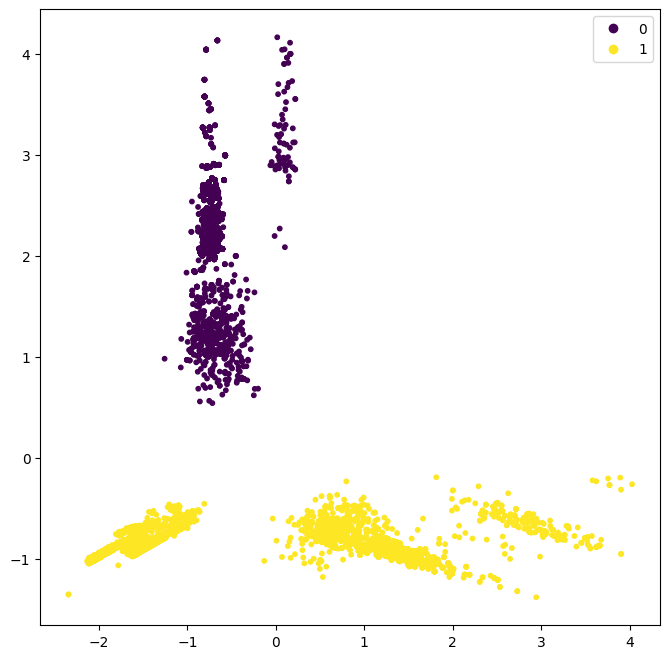

In [123]:

c=df['isKilled'].replace(dict(zip(df['isKilled'].unique(), range(len(df['isKilled'].unique())))))
c = c[dbscan.labels_!=-1]
plt.figure(figsize=(8,8))
#printing the scatter without -1 labels (noise points)
scatter = plt.scatter(df['pc1'][dbscan.labels_!=-1], df['pc2'][dbscan.labels_!=-1], c=c, s=10)
#scatter = plt.scatter(df['pc1'], df['pc2'], c=dbscan.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.legend(*scatter.legend_elements())

## Characterizing clusters with cities

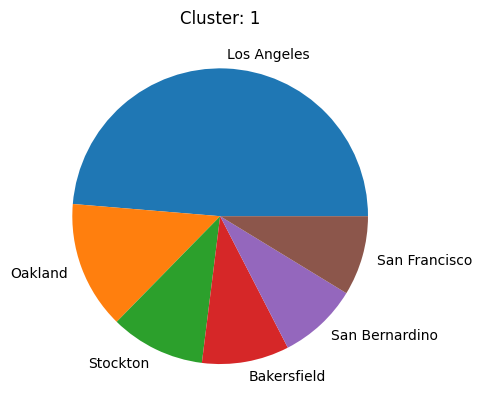

city_or_county
Los Angeles       296
Oakland            85
Stockton           63
Bakersfield        58
San Bernardino     53
San Francisco      53
Name: count, dtype: int64


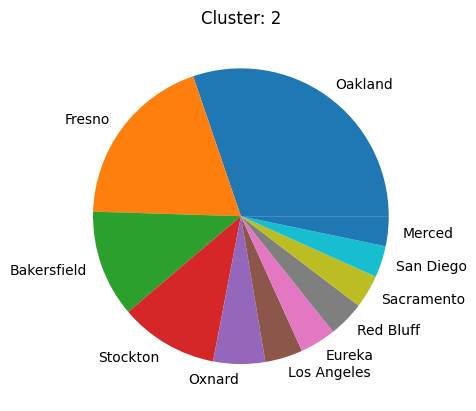

city_or_county
Oakland        491
Fresno         313
Bakersfield    190
Stockton       175
Oxnard          92
Los Angeles     67
Eureka          64
Red Bluff       64
Sacramento      59
San Diego       56
Merced          53
Name: count, dtype: int64


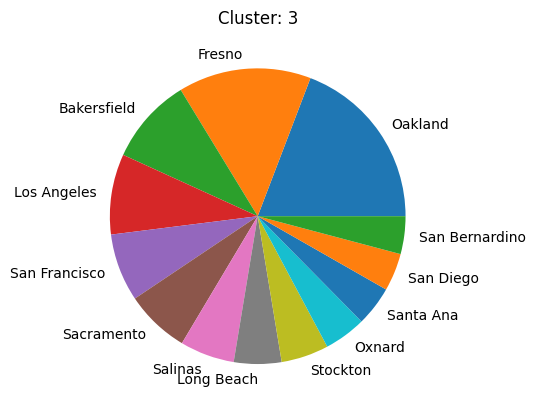

city_or_county
Oakland           251
Fresno            190
Bakersfield       124
Los Angeles       115
San Francisco      97
Sacramento         92
Salinas            78
Long Beach         68
Stockton           68
Oxnard             60
Santa Ana          57
San Diego          54
San Bernardino     54
Name: count, dtype: int64


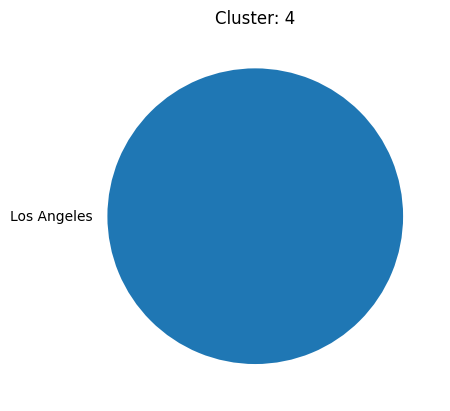

city_or_county
Los Angeles    68
Name: count, dtype: int64


In [124]:
c=df['city_or_county'].replace(dict(zip(df['city_or_county'].unique(), range(len(df['city_or_county'].unique())))))

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    injury_for_clust = df_categorical['city_or_county'].loc[dbscan.labels_ == k].value_counts() 
    injury_for_clust = injury_for_clust[injury_for_clust > 50]
    # Show pie plot
    labels = ['not-injured', 'injured']
    plt.title('Cluster: ' + str(k + 1))
    plt.pie(injury_for_clust, labels= injury_for_clust.index)
    plt.show()
    print(injury_for_clust)

##  Characterizing clusters with incident char

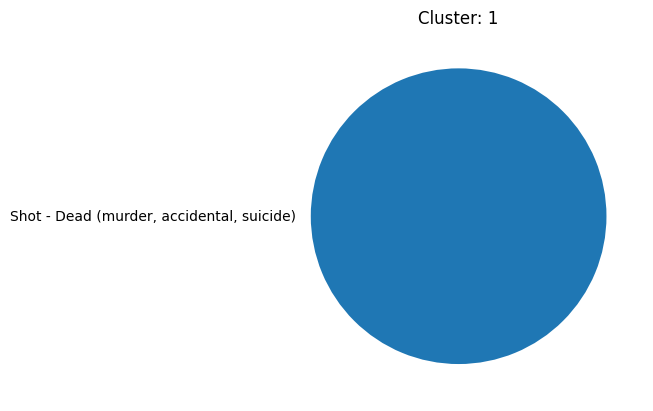

incident_characteristics1
Shot - Dead (murder, accidental, suicide)    1922
Name: count, dtype: int64


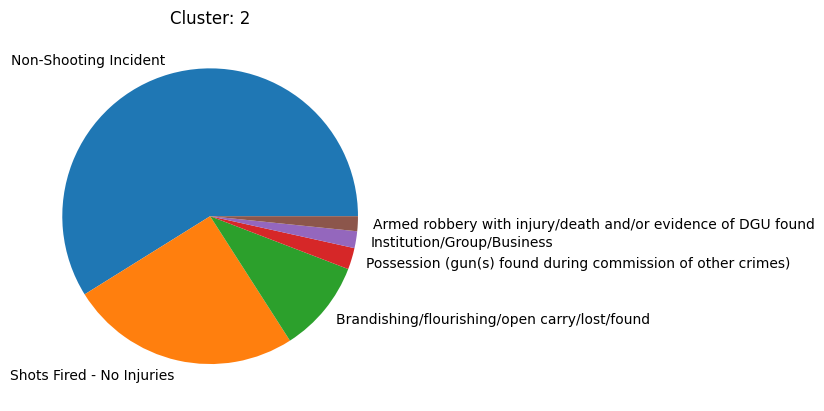

incident_characteristics1
Non-Shooting Incident                                           1952
Shots Fired - No Injuries                                        836
Brandishing/flourishing/open carry/lost/found                    335
Possession (gun(s) found during commission of other crimes)       78
Institution/Group/Business                                        61
Armed robbery with injury/death and/or evidence of DGU found      54
Name: count, dtype: int64


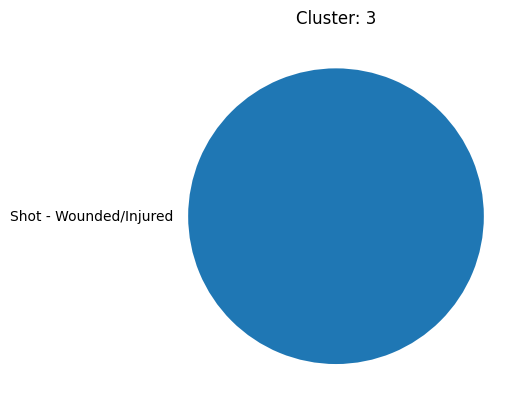

incident_characteristics1
Shot - Wounded/Injured    2394
Name: count, dtype: int64


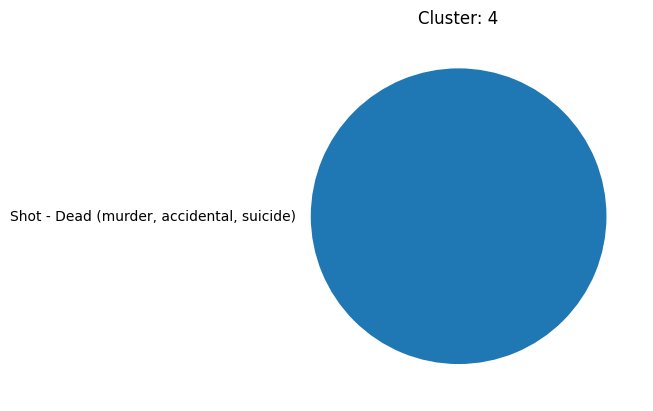

incident_characteristics1
Shot - Dead (murder, accidental, suicide)    603
Name: count, dtype: int64


In [125]:
c=df['incident_characteristics1'].replace(dict(zip(df['incident_characteristics1'].unique(), range(len(df['incident_characteristics1'].unique())))))

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    injury_for_clust = df_categorical['incident_characteristics1'].loc[dbscan.labels_ == k].value_counts() 
    injury_for_clust = injury_for_clust[injury_for_clust > 50]
    # Show pie plot
    labels = ['not-injured', 'injured']
    plt.title('Cluster: ' + str(k + 1))
    plt.pie(injury_for_clust, labels= injury_for_clust.index)
    plt.show()
    print(injury_for_clust)

## Characterizing clusters with arrested, unharmed, killing, injuried

In [126]:
df_task_1 = df_task_1[df_task_1['state'] == 'california']

df_categorical.loc[df_task_1['n_arrested'] > 0, 'involve_arrest'] = 1
df_categorical.loc[df_task_1['n_arrested'] == 0, 'involve_arrest'] = 0

df_categorical.loc[df_task_1['n_unharmed'] > 0, 'involve_unharmed'] = 1
df_categorical.loc[df_task_1['n_unharmed'] == 0, 'involve_unharmed'] = 0

In [156]:
color_map = {0: 'royalblue', 1: 'darkslategrey'}

def get_colors(data):
    return [color_map[val] for val in data.index]

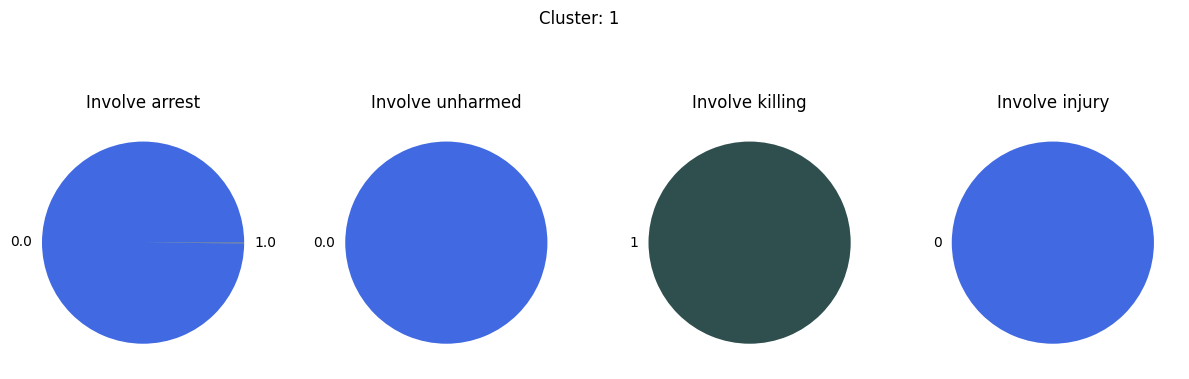

involve_arrest
0.0    1943
1.0       2
Name: count, dtype: int64

involve_unharmed
0.0    1945
Name: count, dtype: int64

isKilled
1    1945
Name: count, dtype: int64

involve_injury
0    1945
Name: count, dtype: int64


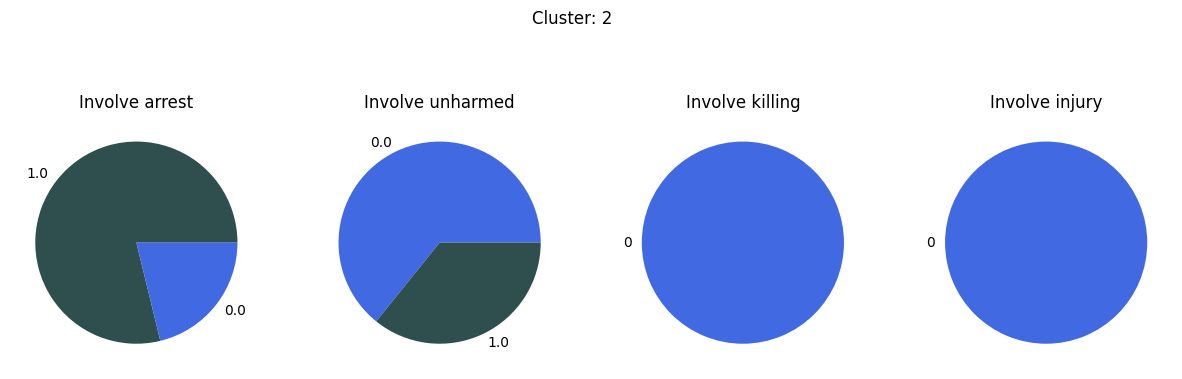

involve_arrest
1.0    2823
0.0     759
Name: count, dtype: int64

involve_unharmed
0.0    2300
1.0    1282
Name: count, dtype: int64

isKilled
0    3582
Name: count, dtype: int64

involve_injury
0    3582
Name: count, dtype: int64


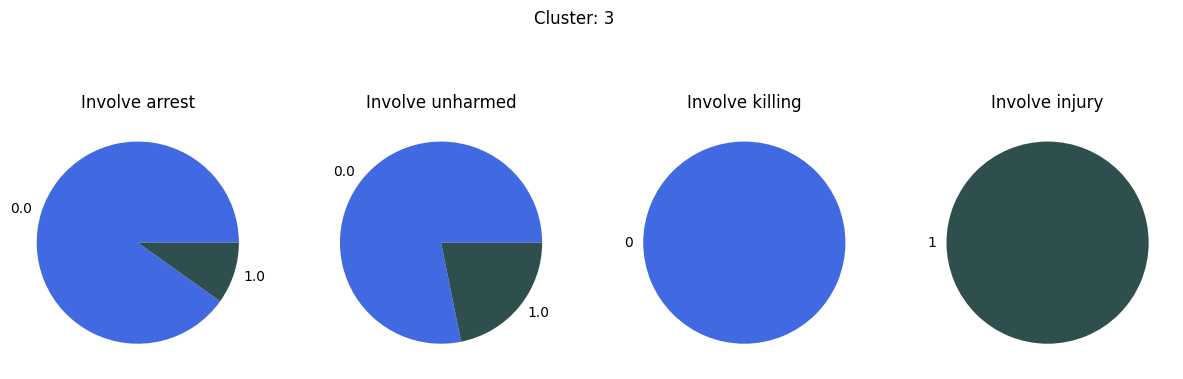

involve_arrest
0.0    2215
1.0     242
Name: count, dtype: int64

involve_unharmed
0.0    1921
1.0     536
Name: count, dtype: int64

isKilled
0    2457
Name: count, dtype: int64

involve_injury
1    2457
Name: count, dtype: int64


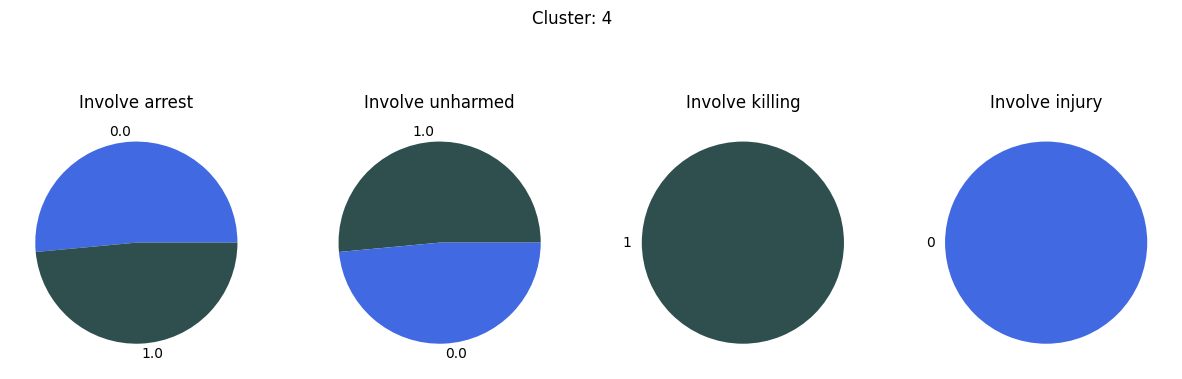

involve_arrest
0.0    314
1.0    296
Name: count, dtype: int64

involve_unharmed
1.0    314
0.0    296
Name: count, dtype: int64

isKilled
1    610
Name: count, dtype: int64

involve_injury
0    610
Name: count, dtype: int64


In [157]:

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    
    n_arrested_clust =  df_categorical["involve_arrest"].loc[dbscan.labels_ == k].value_counts()
    n_unharmed_clust = df_categorical['involve_unharmed'].loc[dbscan.labels_ == k].value_counts() 
    n_killed_clust = df_categorical['isKilled'].loc[dbscan.labels_ == k].value_counts()
    n_injured_clust = df_categorical['involve_injury'].loc[dbscan.labels_ == k].value_counts()

    #showing the two pie plots together
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.suptitle('Cluster: ' + str(k + 1))
    fig.set_figwidth(15)
    ax1.pie(n_arrested_clust, labels= n_arrested_clust.index, colors=get_colors(n_arrested_clust))
    ax2.pie(n_unharmed_clust, labels= n_unharmed_clust.index, colors=get_colors(n_unharmed_clust))
    ax3.pie(n_killed_clust, labels= n_killed_clust.index, colors=get_colors(n_killed_clust))
    ax4.pie(n_injured_clust, labels= n_injured_clust.index, colors=get_colors(n_injured_clust))

    #adding ax1 and ax2 titles
    ax1.set_title('Involve arrest')
    ax2.set_title('Involve unharmed')
    ax3.set_title('Involve killing')
    ax4.set_title('Involve injury')

    #change the colors of the pie plots
    

    plt.show()

    print(n_arrested_clust)
    print()
    print(n_unharmed_clust)
    print()
    print(n_killed_clust)
    print()
    print(n_injured_clust)


Where 0 represents the absence of the feature and 1 signifies its presence

## Best clustering method
From our experiments we obtained the best performances from the DB_Scan Clustering, so we selected it as our final method by looking at the distribution of the clusters and to the distribution of incidents involving at least one death or no death in each cluster.